In [19]:
%reload_ext autoreload
%autoreload 2
import torch
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *
# from src.TunableAttentionRegression import TunableAttentionRegression
from src import utils
from src import tokenize
from CustomDatasets.PeptidesWithRetentionTimes import PeptidesWithRetentionTimes


In [20]:
class TunableAttentionRegression(torch.nn.Module):
    def __init__(self, input_size = 2707, hidden_size = 64,
                output_size = 1, numberOfHeads = 16) -> None:
        super(TunableAttentionRegression, self).__init__()
        self.embedding = torch.nn.Embedding(input_size, 32)
        self.lstm = torch.nn.LSTM(32, hidden_size, batch_first=True)
        self.attention = torch.nn.MultiheadAttention(hidden_size, num_heads=numberOfHeads, batch_first=True) #https://pytorch.org/docs/stable/generated/torch.ao.nn.quantizable.MultiheadAttention.html#multiheadattention
        self.linear1 = torch.nn.Linear(hidden_size*200, output_size, dtype=torch.float32)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x) -> torch.Tensor:
        # print(x.shape)
        x = x.view(x.size(0), x.size(2)*2)
        # print(x.shape)
        embedded = self.embedding(x)
        # print(embedded.shape)
        # embedded = embedded.view(*x.size(), -1) #to make it 3D
        lstm_out, _ = self.lstm(embedded)
        # print(lstm_out.shape)
        # lstm_out = lstm_out.permute(1, 0, 2)  # [seq_len, batch, hidden_size]
        # print(lstm_out.shape)
        query = lstm_out.permute(0, 1, 2)
        key = lstm_out.permute(0, 1, 2)
        value = lstm_out.permute(0, 1, 2)
        # print(query.shape, key.shape, value.shape)
        attention_output, _ = self.attention(query, key, value)
        # print(attention_output.shape)
        attention_output_as_2d = attention_output.reshape(attention_output.size(0), attention_output.size(1)*attention_output.size(2))
        # print(attention_output_as_2d.shape)
        output = self.linear1(attention_output_as_2d)
        # print(output.shape)
        # print(output)
        return output

In [21]:
#load models
trypsin_model = TunableAttentionRegression(hidden_size=64, numberOfHeads=8)
mp_model = TunableAttentionRegression(hidden_size=64, numberOfHeads=8)

trypsin_model.load_state_dict(torch.load("trypsin_lsm_attention_100.pt"))
mp_model.load_state_dict(torch.load("mp_lsm_attention_100.pt"))

trypsin_model.eval()
mp_model.eval()

trypsin_model_predictions_tryptic_data = []
trypsin_model_predictions_mp_data = []
mp_model_predictions_mp_data = []
mp_model_predictions_tryptic_data = []

#load vocab
vocab = tokenize.readVocabulary("vocab.csv")

#tryptic data
tryptic_test_data = pd.read_csv(r"trypsin_test_set.csv", index_col=None, header=0, usecols=["FullSequence", "Mean"])
tryptic_testing_tokens = tokenize.tokenizePreTokens(tokenize.getPreTokens(tryptic_test_data), vocab, 100, tokenize.TokenFormat.TwoDimensional)

tryptic_sequences = []
tryptic_retention_times = []

for i in tryptic_testing_tokens:
    tryptic_sequences.append(i[0])
    tryptic_retention_times.append(i[1])

tryptic_dataset = PeptidesWithRetentionTimes(tryptic_sequences, tryptic_retention_times)

#mp data
mp_test_data = pd.read_csv(r"multiprotease_test_set.csv", index_col=None, header=0, usecols=["Full Sequence", "Scan Retention Time"])
mp_testing_tokens = tokenize.tokenizePreTokens(tokenize.getPreTokens(mp_test_data), vocab, 100, tokenize.TokenFormat.TwoDimensional)

mp_sequences = []
mp_retention_times = []

for i in mp_testing_tokens:
    mp_sequences.append(i[0])
    mp_retention_times.append(i[1])

mp_dataset = PeptidesWithRetentionTimes(mp_sequences, mp_retention_times)


#eval mode
trypsin_model.eval()
mp_model.eval()

#make dataloaders
tryptic_dataloader = torch.utils.data.DataLoader(tryptic_dataset, batch_size=1, shuffle=False)
mp_dataloader = torch.utils.data.DataLoader(mp_dataset, batch_size=1, shuffle=False)

c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sequence = str(row[0])
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.append((sequence, row[1]))
c:\Users\elabo\Documents\GitHub\RetentionTimeEstimators\src\tokenize.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  preTokens.

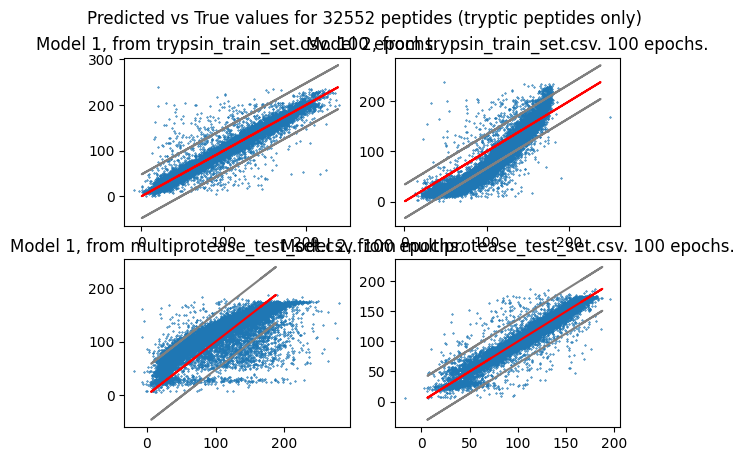

In [23]:

for i, data in enumerate(tryptic_dataloader):
    #model 1
    with torch.no_grad():
        inputs, labels = data

        outputs = trypsin_model(inputs)
        predicted = outputs
        trypsin_model_predictions_tryptic_data.append((labels, predicted))

    #model 2
    with torch.no_grad():
        inputs, labels = data

        outputs = mp_model(inputs)
        predicted = outputs
        mp_model_predictions_tryptic_data.append((labels, predicted))



for i, data in enumerate(mp_dataloader):
    #model 1
    with torch.no_grad():
        inputs, labels = data

        outputs = trypsin_model(inputs)
        predicted = outputs
        trypsin_model_predictions_mp_data.append((labels, predicted))

    #model 2
    with torch.no_grad():
        inputs, labels = data

        outputs = mp_model(inputs)
        predicted = outputs
        mp_model_predictions_mp_data.append((labels, predicted))

trypsin_model_predictions_tryptic_flatten = []
trypsin_model_predictions_mp_flatten = []
mp_model_predictions_tryptic_flatten = []
mp_model_predictions_mp_flatten = []
real_labels_tryptic = []
real_labels_mp = []

for label, pred in trypsin_model_predictions_tryptic_data:
    trypsin_model_predictions_tryptic_flatten.append(pred)
    real_labels_tryptic.append(label)

for label, pred in mp_model_predictions_mp_data:
    mp_model_predictions_mp_flatten.append(pred)
    real_labels_mp.append(label)

for label, pred in trypsin_model_predictions_mp_data:
    trypsin_model_predictions_mp_flatten.append(pred)

for label, pred in mp_model_predictions_tryptic_data:
    mp_model_predictions_tryptic_flatten.append(pred)



#flatten the lists
trypsin_model_predictions_tryptic_flatten = torch.stack(trypsin_model_predictions_tryptic_flatten).flatten().tolist()
trypsin_model_predictions_mp_flatten = torch.stack(trypsin_model_predictions_mp_flatten).flatten().tolist()
mp_model_predictions_tryptic_flatten = torch.stack(mp_model_predictions_tryptic_flatten).flatten().tolist()
mp_model_predictions_mp_flatten = torch.stack(mp_model_predictions_mp_flatten).flatten().tolist()
real_labels_tryptic = torch.stack(real_labels_tryptic).flatten().tolist()
real_labels_mp = torch.stack(real_labels_mp).flatten().tolist()




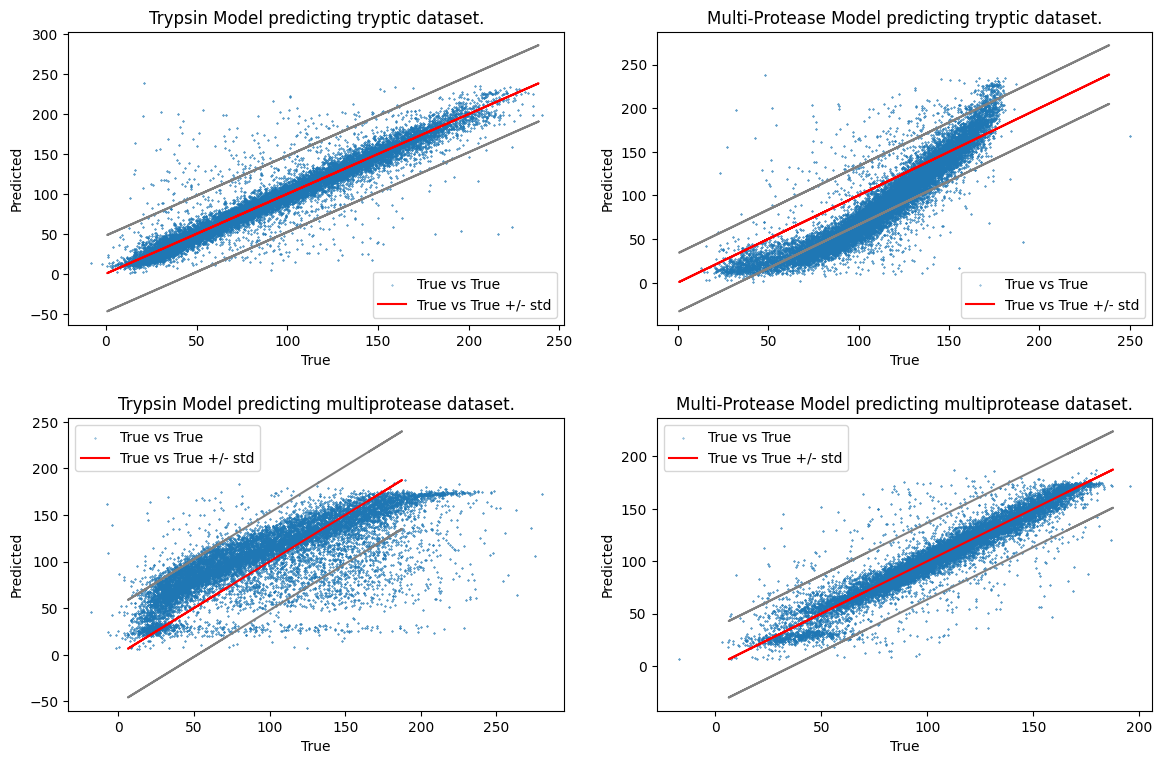

In [28]:

# chronologer_df = pd.read_csv("out.tsv", sep="\t")
# chronologer_df = chronologer_df["Pred_HI"].apply(lambda x: x*10).tolist()
# chronologer_labels = pd.read_csv("out.tsv", sep="\t")
# chronologer_labels = chronologer_labels["1"].tolist()


#tryptic data plot for both models
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(trypsin_model_predictions_tryptic_flatten, real_labels_tryptic, s=0.1)
axs[0, 0].plot(real_labels_tryptic, real_labels_tryptic, color='red')
axs[0, 0].plot(real_labels_tryptic, real_labels_tryptic - torch.std(torch.tensor(trypsin_model_predictions_tryptic_flatten)).numpy(), color='gray')
axs[0, 0].plot(real_labels_tryptic, real_labels_tryptic + torch.std(torch.tensor(trypsin_model_predictions_tryptic_flatten)).numpy(), color='gray')
axs[0, 0].set_title('Trypsin Model predicting tryptic dataset.')
axs[0, 1].scatter(mp_model_predictions_tryptic_flatten, real_labels_tryptic, s=0.1)
axs[0, 1].plot(real_labels_tryptic, real_labels_tryptic, color='red')
axs[0, 1].plot(real_labels_tryptic, real_labels_tryptic - torch.std(torch.tensor(mp_model_predictions_tryptic_flatten)).numpy(), color='gray')
axs[0, 1].plot(real_labels_tryptic, real_labels_tryptic + torch.std(torch.tensor(mp_model_predictions_tryptic_flatten)).numpy(), color='gray')
axs[0, 1].set_title('Multi-Protease Model predicting tryptic dataset.')
axs[1, 0].scatter(trypsin_model_predictions_mp_flatten, real_labels_mp, s=0.1)
axs[1, 0].plot(real_labels_mp, real_labels_mp, color='red')
axs[1, 0].plot(real_labels_mp, real_labels_mp - torch.std(torch.tensor(trypsin_model_predictions_mp_flatten)).numpy(), color='gray')
axs[1, 0].plot(real_labels_mp, real_labels_mp + torch.std(torch.tensor(trypsin_model_predictions_mp_flatten)).numpy(), color='gray')
axs[1, 0].set_title('Trypsin Model predicting multiprotease dataset.')
axs[1, 1].scatter(mp_model_predictions_mp_flatten, real_labels_mp, s=0.1)
axs[1, 1].plot(real_labels_mp, real_labels_mp, color='red')
axs[1, 1].plot(real_labels_mp, real_labels_mp - torch.std(torch.tensor(mp_model_predictions_mp_flatten)).numpy(), color='gray')
axs[1, 1].plot(real_labels_mp, real_labels_mp + torch.std(torch.tensor(mp_model_predictions_mp_flatten)).numpy(), color='gray')
axs[1, 1].set_title('Multi-Protease Model predicting multiprotease dataset.')
# #make plots bigger 
fig.set_size_inches(12, 8)
# #axis for all plots
for ax in axs.flat:
    ax.set(xlabel='True', ylabel='Predicted')
# #increase the space between plots
fig.tight_layout(pad=2.0)
#add legend to each plot to explain the red line (labels vs labels) and the gray lines (labels vs labels +/- std)
axs[0, 0].legend(["True vs True", "True vs True +/- std"])
axs[0, 1].legend(["True vs True", "True vs True +/- std"])
axs[1, 0].legend(["True vs True", "True vs True +/- std"])
axs[1, 1].legend(["True vs True", "True vs True +/- std"])
plt.show()


In [ ]:
#now without mods
dataset = TestingTensorsDataset("testingTensorsWithoutMods")
dataset[0][0].shape, dataset[0][1].shape
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trypsin_model = TunableAttentionRegression1(hidden_size=64, numberOfHeads=8).to(device)
mp_model = TunableAttentionRegression2(hidden_size=64, numberOfHeads=8).to(device)
model_3 = TunableAttentionRegression3(hidden_size=64, numberOfHeads=8).to(device)

trypsin_model.load_state_dict(torch.load("7thTry_model_hs_64_droput_epoch_99.pt"))
mp_model.load_state_dict(torch.load("second_7thTry_model_hs_64_droput_epoch_99.pt"))
model_3.load_state_dict(torch.load("third_7thTry_model_hs_64_droput_epoch_199.pt"))

trypsin_model.eval()
mp_model.eval()
model_3.eval()
trypsin_model_predictions = []
mp_model_predictions = []
model_3_predictions = []

for i, data in enumerate(dataset):

    #model 1
    with torch.no_grad():
        inputs, labels = data

        outputs = trypsin_model(inputs.to(device)).to(device)
        predicted = outputs
        trypsin_model_predictions.append((labels, predicted))

    #model 2
    with torch.no_grad():
        inputs, labels = data

        outputs = mp_model(inputs.to(device)).to(device)
        predicted = outputs
        mp_model_predictions.append((labels, predicted))
    
    #model 3
    with torch.no_grad():
        inputs, labels = data

        outputs = model_3(inputs.to(device)).to(device)
        predicted = outputs
        model_3_predictions.append((labels, predicted))
trypsin_model_predictions_flatten = []
mp_model_predictions_flatten = []
model_3_predictions_flatten = []
real_labels = []
for label, pred in trypsin_model_predictions:
    trypsin_model_predictions_flatten.append(pred)
    real_labels.append(label)

for label, pred in mp_model_predictions:
    mp_model_predictions_flatten.append(pred)

for label, pred in model_3_predictions:
    model_3_predictions_flatten.append(pred)


trypsin_model_predictions_flatten = torch.stack(trypsin_model_predictions_flatten).flatten().tolist()
mp_model_predictions_flatten = torch.stack(mp_model_predictions_flatten).flatten().tolist()
model_3_predictions_flatten = torch.stack(model_3_predictions_flatten).flatten().tolist()
real_labels = torch.stack(real_labels).flatten()
fig, axs = plt.subplots(2, 2)
#add to suptitle sample size
fig.suptitle(f"Predicted vs True values for {len(real_labels)} peptides (without modified peptides)")
axs[0, 0].scatter(trypsin_model_predictions_flatten, real_labels, s=0.1)
axs[0, 0].plot(real_labels, real_labels, color='red')
axs[0, 0].set_title('Model 1, from allPeptides file. 100 epochs.')
axs[0, 1].scatter(mp_model_predictions_flatten, real_labels, s=0.1)
axs[0, 1].plot(real_labels, real_labels, color='red')
axs[0, 1].set_title('Model 2, from allPeptides file filtered by PEP < 0.1. 100 epochs.')
axs[1, 0].scatter(model_3_predictions_flatten, real_labels, s=0.1)
axs[1, 0].plot(real_labels, real_labels, color='red')
axs[1, 0].set_title('Model 3, from allPeptides file filtered by PEP < 0.1. 200 epochs.')
#add r2 score to the plot
m1R2 = r2_score(real_labels, trypsin_model_predictions_flatten)
m2R2 = r2_score(real_labels, mp_model_predictions_flatten)
m3R2 = r2_score(real_labels, model_3_predictions_flatten)
#add scores to each corresponfing plot, upper left rounded to 2 decimal places
axs[0, 0].text(0.05, 0.95, f"R2: {m1R2:.2f}", transform=axs[0, 0].transAxes)
axs[0, 1].text(0.05, 0.95, f"R2: {m2R2:.2f}", transform=axs[0, 1].transAxes)
axs[1, 0].text(0.05, 0.95, f"R2: {m3R2:.2f}", transform=axs[1, 0].transAxes)
#add standard deviation to the plot, these are list of tensors so we need to convert them to numpy arrays
m1std = torch.std(real_labels - torch.tensor(trypsin_model_predictions_flatten)).numpy()
m2std = torch.std(real_labels - torch.tensor(mp_model_predictions_flatten)).numpy()
m3std = torch.std(real_labels - torch.tensor(model_3_predictions_flatten)).numpy()
#add scores to each corresponfing plot, upper left rounded to 2 decimal places
axs[0, 0].text(0.05, 0.90, f"std: {m1std:.2f}", transform=axs[0, 0].transAxes)
axs[0, 1].text(0.05, 0.90, f"std: {m2std:.2f}", transform=axs[0, 1].transAxes)
axs[1, 0].text(0.05, 0.90, f"std: {m3std:.2f}", transform=axs[1, 0].transAxes)
#make plots bigger 
fig.set_size_inches(12, 8)
#axis for all plots
for ax in axs.flat:
    ax.set(xlabel='True', ylabel='Predicted')
#increase the space between plots
fig.tight_layout(pad=2.0)
plt.show()

#save the plot
fig.savefig("3ModelsPredictedVsTrue_noMods.png")

NameError: name 'TestingTensorsDataset' is not defined

In [ ]:
%reload_ext autoreload
%autoreload 2
from src.utils import read_batched_tensor_get_chronologer_format
from src.tokenize import readVocabulary
dataset = TestingTensorsDataset("testingTensors")
vocab = readVocabulary("vocab.csv")
#convert to chronologer format
# print(vocab)
def get_swap_dict(d):
    return {v: k for k, v in d.items()}
vocab = get_swap_dict(vocab)
# print(vocab)
chronologer_format = read_batched_tensor_get_chronologer_format(dataset, vocab)
chronologer_format


[('CC[+57.021464]C[+57.021464]C[+57.021464]C[+57.021464]C[+57.021464]ER',
  69.07275),
 ('KIEEAMMDGSETPQLFTVLPEK', 110.01118666666666),
 ('NAINIEELFQGISR', 170.4624485714286),
 ('EHDQLIEK', 37.8955725),
 ('LSGENGDEVKKE', 13.70959),
 ('VEVCC[+57.021464]KDESVDLEEFR', 94.254354),
 ('GDFIHVMDNSDPNWWK', 141.08517363636363),
 ('GQVCC[+57.021464]LPVISAENWKPATK', 105.155692),
 ('HSVQCC[+57.021464]LVVDK', 27.30251),
 ('NAPVTFIVDGAVVK', 116.06905888888888),
 ('WYQMMC[+57.021464]DR', 107.91833666666666),
 ('ILMLGLDAAGK', 119.68929545454544),
 ('APPHELTEEEKQQILHSEEFLSFFDHSTR', 136.62653),
 ('QTATILSMDKDCC[+57.021464]LR', 66.34365),
 ('EYWMDPEGEMMKPGR', 66.59900272727273),
 ('LVAEPSGSESSMEQVLFPK', 123.81172),
 ('RPLGVDVQR', 36.43726),
 ('VSFLSALEEYTK', 172.70526),
 ('GCC[+57.021464]PLEAAPLPAEVR', 91.604735),
 ('ILESELEEQLSQHR', 93.95431299999998),
 ('GDIINEVVLK', 113.26576),
 ('HLEVSSASMAEDLCC[+57.021464]R', 66.58159),
 ('AGGTGLER', 37.47009),
 ('KLNEQSPTR', 20.60571857142857),
 ('ISHLVLPVQPENALK',

In [ ]:
df = pd.DataFrame(chronologer_format)
df.to_csv("testingData_as_chronologer_format.tsv", index=False, sep="\t")